In [1]:
# IMPORTS
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.decomposition import PCA
import pandas as pd
import os
from typing import List, Dict, Tuple

# Linear network with null-space in weight matrices


In [2]:
class Net(nn.Module):
    '''
    Small width. Depth is adjustable.
    '''
    def __init__(self, width=20, depth=1, d=2):
        super(Net, self).__init__()

        self.depth = depth
        self.w = nn.Linear(d, width, bias=False)
        self.w.weight.data.normal_(0, d ** -0.5)

        # middle layers (if depth > 2)
        self.hidden = nn.ModuleList()
        for _ in range(depth - 2):
            layer = nn.Linear(width, width, bias=False)
            layer.weight.data.normal_(0, width ** -0.5)
            self.hidden.append(layer)

        self.u = nn.Linear(width, d, bias=False)
        self.u.weight.data.normal_(0, width ** -0.5)

    def forward(self, x):
        x = self.w(x)
        for layer in self.hidden:
            x = layer(x)
        x = self.u(x)
        return x

# Library of optimization functions
Collection of functions for optimizing the neural network.

In [3]:
def gradient_descent(model, X, y, lr=0.05, n_steps=50):
    """
    Classic gradient descent (full batch).
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    loss_fn = nn.MSELoss()

    trajectory = []
    losses = []

    with torch.no_grad():
        flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
        trajectory.append(flat_params.cpu().numpy())
        losses.append(loss_fn(model(X), y).item())

    for _ in range(n_steps):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
            trajectory.append(flat_params.cpu().numpy())
            losses.append(loss_fn(model(X), y).item())

    return (np.array(trajectory), model, np.array(losses))


def sgd(model, X, y, lr=0.05, n_steps=50, batch_size=32):
    """
    Stochastic gradient descent with mini-batches.
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    loss_fn = nn.MSELoss()

    trajectory = []
    losses = []

    with torch.no_grad():
        flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
        trajectory.append(flat_params.cpu().numpy())
        losses.append(loss_fn(model(X), y).item())

    n_samples = X.shape[0]

    for _ in range(n_steps):
        # Random mini-batch
        indices = torch.randperm(n_samples)[:batch_size]
        X_batch = X[indices]
        y_batch = y[indices]

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
            trajectory.append(flat_params.cpu().numpy())
            losses.append(loss_fn(model(X), y).item())  # Full dataset loss

    return (np.array(trajectory), model, np.array(losses))


def gradient_descent_momentum(model, X, y, lr=0.05, momentum=0.9, n_steps=50):
    """
    Gradient descent with momentum.
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.MSELoss()

    trajectory = []
    losses = []

    with torch.no_grad():
        flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
        trajectory.append(flat_params.cpu().numpy())
        losses.append(loss_fn(model(X), y).item())

    for _ in range(n_steps):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
            trajectory.append(flat_params.cpu().numpy())
            losses.append(loss_fn(model(X), y).item())

    return (np.array(trajectory), model, np.array(losses))


def gradient_descent_adam(model, X, y, lr=0.05, n_steps=50):
    """
    Gradient descent with Adam optimizer.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    trajectory = []
    losses = []

    with torch.no_grad():
        flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
        trajectory.append(flat_params.cpu().numpy())
        losses.append(loss_fn(model(X), y).item())

    for _ in range(n_steps):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
            trajectory.append(flat_params.cpu().numpy())
            losses.append(loss_fn(model(X), y).item())

    return (np.array(trajectory), model, np.array(losses))


def sgd_weight_decay(model, X, y, lr=0.05, n_steps=50, weight_decay=0.01):
    """
    Gradient descent with weight decay (L2 regularization).
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    trajectory = []
    losses = []

    with torch.no_grad():
        flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
        trajectory.append(flat_params.cpu().numpy())
        losses.append(loss_fn(model(X), y).item())

    for _ in range(n_steps):
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            flat_params = torch.cat([p.flatten() for p in model.parameters()]).clone()
            trajectory.append(flat_params.cpu().numpy())
            losses.append(loss_fn(model(X), y).item())

    return (np.array(trajectory), model, np.array(losses))

# Plotting functions (PCA)

In [4]:
def plot_loss_surface_2d_pca(model, X, y, title, alpha_range=(-3, 3), beta_range=(-3, 3), trajectory=None, reference_params=None, ax=None, shared_directions=None):
    """
    2D loss surface plot using shared PCA directions or trajectory-specific PCA.

    Args:
        model: the trained Net model (nn.Module)
        X, y: input and target tensors
        alpha_range, beta_range: tuples specifying min/max for 2D grid
        trajectory: optional, flattened parameters trajectory (steps x num_params)
        reference_params: optional, center point for the loss surface
        ax: optional matplotlib axis to plot on (for subplots)
        shared_directions: optional, pre-computed PCA directions (v1, v2) to use for all plots
    """
    if reference_params is None:
        theta_0 = torch.cat([p.detach().flatten() for p in model.parameters()]).numpy()
    else:
        theta_0 = reference_params

    n_params = len(theta_0)

    # Use shared directions if provided, otherwise compute from trajectory
    if shared_directions is not None:
        v1, v2 = shared_directions
    elif trajectory is not None and len(trajectory) > 2:
        pca = PCA(n_components=2)
        pca.fit(trajectory - theta_0)
        v1, v2 = pca.components_
    else:
        # Fallback to random
        np.random.seed(0)
        v1 = np.random.randn(n_params)
        v2 = np.random.randn(n_params)
        v1 /= np.linalg.norm(v1)
        v2 /= np.linalg.norm(v2)

    alpha_vals = np.linspace(*alpha_range, 100)
    beta_vals = np.linspace(*beta_range, 100)
    Alpha, Beta = np.meshgrid(alpha_vals, beta_vals)
    Loss = np.zeros_like(Alpha)

    # Create a FRESH model just for evaluating the loss surface
    temp_model = Net(width=model.w.out_features, depth=model.depth, d=model.w.in_features)

    for i in range(Alpha.shape[0]):
        for j in range(Alpha.shape[1]):
            theta_temp = theta_0 + Alpha[i, j]*v1 + Beta[i, j]*v2
            idx = 0
            for p in temp_model.parameters():
                n = p.numel()
                p.data = torch.from_numpy(theta_temp[idx:idx+n]).view_as(p).float()
                idx += n
            with torch.no_grad():
                y_pred = temp_model(X)
                Loss[i, j] = ((y_pred - y)**2).mean().item()

    # Create figure if ax not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
        show_plot = True
    else:
        show_plot = False

    contour = ax.contourf(Alpha, Beta, np.log(Loss + 1e-8), levels=50, cmap="viridis")
    plt.colorbar(contour, ax=ax, label="log(loss)")

    if trajectory is not None:
        traj_proj = []
        for t in trajectory:
            t = t - theta_0
            a = np.dot(t, v1)
            b = np.dot(t, v2)
            traj_proj.append([a, b])
        traj_proj = np.array(traj_proj)

        # Plot trajectory with color gradient from red to green
        n_points = len(traj_proj)
        for i in range(n_points - 1):
            # Interpolate color from red (1, 0, 0) to green (0, 1, 0)
            color_ratio = i / (n_points - 1)
            color = (1 - color_ratio, color_ratio, 0)  # (R, G, B)
            ax.plot(traj_proj[i:i+2, 0], traj_proj[i:i+2, 1],
                   'o-', color=color, markersize=3, linewidth=1)

    ax.set_title(title)
    ax.set_xlabel("alpha (PC1 dir)")
    ax.set_ylabel("beta (PC2 dir)")

    if show_plot:
        plt.show()

In [5]:
def plot_loss_surface_3d_pca(model, X, y, title, trajectory, alpha_range=(-3, 3), beta_range=(-3, 3), reference_params=None, ax=None, shared_directions=None):
    """
    3D loss surface using shared PCA directions or trajectory-specific PCA.

    Args:
        model: trained Net (only used for architecture info)
        X, y: input/target tensors
        trajectory: flattened parameter trajectory (steps x num_params)
        alpha_range, beta_range: ranges for 2D slice
        title: plot title
        reference_params: optional center point for loss surface
        ax: optional matplotlib 3D axis to plot on (for subplots)
        shared_directions: optional, pre-computed PCA directions (v1, v2) to use for all plots
    """
    # Use shared reference point
    if reference_params is None:
        theta_0 = torch.cat([p.detach().flatten() for p in model.parameters()]).numpy()
    else:
        theta_0 = reference_params

    # Use shared directions if provided, otherwise compute from trajectory
    if shared_directions is not None:
        v1, v2 = shared_directions
    elif trajectory is not None and len(trajectory) > 2:
        pca = PCA(n_components=2)
        pca.fit(trajectory - theta_0)
        v1, v2 = pca.components_
    else:
        # Fallback to random
        np.random.seed(0)
        v1 = np.random.randn(len(theta_0))
        v2 = np.random.randn(len(theta_0))
        v1 /= np.linalg.norm(v1)
        v2 /= np.linalg.norm(v2)

    # Create 2D grid
    alpha_vals = np.linspace(*alpha_range, 50)
    beta_vals = np.linspace(*beta_range, 50)
    Alpha, Beta = np.meshgrid(alpha_vals, beta_vals)
    Loss = np.zeros_like(Alpha)

    # Create a FRESH model for computing loss surface
    temp_model = Net(width=model.w.out_features, depth=model.depth, d=model.w.in_features)

    # Compute loss on the grid
    for i in range(Alpha.shape[0]):
        for j in range(Alpha.shape[1]):
            theta_temp = theta_0 + Alpha[i,j]*v1 + Beta[i,j]*v2

            # Load parameters into temp model
            idx = 0
            for p in temp_model.parameters():
                n = p.numel()
                p.data = torch.from_numpy(theta_temp[idx:idx+n]).view_as(p).float()
                idx += n

            with torch.no_grad():
                y_pred = temp_model(X)
                Loss[i,j] = ((y_pred - y)**2).mean().item()

    # Create figure if ax not provided
    if ax is None:
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111, projection='3d')
        show_plot = True
    else:
        show_plot = False
        fig = ax.figure

    # Plot surface
    surf = ax.plot_surface(Alpha, Beta, Loss, cmap='viridis', alpha=0.8)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Loss")

    # Project trajectory onto the PCA plane
    traj_proj = []
    traj_loss = []
    for t in trajectory:
        t_rel = t - theta_0
        a = np.dot(t_rel, v1)
        b = np.dot(t_rel, v2)
        traj_proj.append([a, b])

        # Loss at this trajectory point
        theta_temp = theta_0 + a*v1 + b*v2
        idx = 0
        for p in temp_model.parameters():
            n = p.numel()
            p.data = torch.from_numpy(theta_temp[idx:idx+n]).view_as(p).float()
            idx += n

        with torch.no_grad():
            y_pred = temp_model(X)
            traj_loss.append(((y_pred - y)**2).mean().item())

    traj_proj = np.array(traj_proj)
    traj_loss = np.array(traj_loss)

    # Plot trajectory with color gradient from red to green
    n_points = len(traj_proj)
    for i in range(n_points - 1):
        # Interpolate color from red (1, 0, 0) to green (0, 1, 0)
        color_ratio = i / (n_points - 1)
        color = (1 - color_ratio, color_ratio, 0)  # (R, G, B)
        ax.plot(traj_proj[i:i+2, 0], traj_proj[i:i+2, 1], traj_loss[i:i+2],
               'o-', color=color, markersize=3, linewidth=1)

    ax.set_xlabel("alpha (PC1 dir)")
    ax.set_ylabel("beta (PC2 dir)")
    ax.set_zlabel("Loss")
    ax.set_title(title)

    if show_plot:
        plt.show()

# Initialize data

In [28]:
def make_2d_eigen_data(n=200, eigvals=[1.0, 0.1], noise=0.1, seed=None):
    '''
    The smaller the second eigenvalue is, the closer we approximate to rank-deficient data.
    '''
    if seed is not None:
        np.random.seed(seed)

    d = len(eigvals)
    # Random orthogonal matrix for eigenvectors
    Q, _ = np.linalg.qr(np.random.randn(d, d))
    Sigma = Q @ np.diag(eigvals) @ Q.T
    X = np.random.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n)

    # Ground-truth maapping (simple, fixed)
    true_w = np.array([[1.0], [1.0]])
    y = X @ true_w + noise * np.random.randn(n, 1)
    return X, y, true_w

# Trajectory plots
For each optimizer, on synthetic data.

In [29]:
def run_optimizer_comparison(eigvals, description, n_samples=1000, width=20, depth=3, n_steps=200, seed=1):
    """
    Run all optimizers on data with specified eigenvalues.

    Returns:
        dict with 'optimizer_info', 'X', 'y' keys
    """
    print(f"\n{'='*60}")
    print(f"Testing: {description}")
    print(f"{'='*60}")

    # Generate data
    X_np, y_np, w_true = make_2d_eigen_data(
        n=n_samples, eigvals=eigvals, noise=0.1, seed=seed
    )
    X = torch.from_numpy(X_np).float()
    y = torch.from_numpy(y_np).float()

    d_input = len(eigvals)

    # Train all optimizers
    traj_gd, model_gd, losses_gd = gradient_descent(
        Net(width=width, depth=depth, d=d_input), X, y, lr=0.15, n_steps=n_steps)
    traj_sgd, model_sgd, losses_sgd = sgd(
        Net(width=width, depth=depth, d=d_input), X, y, lr=0.1, n_steps=n_steps)
    traj_momentum, model_momentum, losses_momentum = gradient_descent_momentum(
        Net(width=width, depth=depth, d=d_input), X, y, lr=0.1, momentum=0.9, n_steps=n_steps)
    traj_adam, model_adam, losses_adam = gradient_descent_adam(
        Net(width=width, depth=depth, d=d_input), X, y, lr=0.005, n_steps=n_steps)
    traj_sgdwd, model_sgdwd, losses_sgdwd = sgd_weight_decay(
        Net(width=width, depth=depth, d=d_input), X, y, lr=0.1, weight_decay=0.01, n_steps=n_steps)

    optimizer_info = {
        "GD": (traj_gd, model_gd, losses_gd),
        "SGD": (traj_sgd, model_sgd, losses_sgd),
        "Momentum": (traj_momentum, model_momentum, losses_momentum),
        "Adam": (traj_adam, model_adam, losses_adam),
        "WD": (traj_sgdwd, model_sgdwd, losses_sgdwd)
    }

    # Print final losses
    print("\nFinal Losses:")
    for name, (_, _, losses) in optimizer_info.items():
        print(f"  {name}: {losses[-1]:.6f}")

    # Reference point for plotting this experiment
    reference_model = Net(width=width, depth=depth, d=d_input)
    reference_params = torch.cat([p.detach().flatten() for p in reference_model.parameters()]).numpy()

    return {
        'optimizer_info': optimizer_info,
        'X': X,
        'y': y,
        'width': width,
        'depth': depth,
        'd_input': d_input,
        'reference_params': reference_params
    }


# ===============
# RUN EXPERIMENTS
# ===============
N_SAMPLES = 1000
WIDTH = 20
DEPTH = 3
N_STEPS = 200
MAX_RETRIES = 5

# Define conditions to test
conditions = [
    ([1.0, 0.9], "Well-conditioned (κ=1.1)"),
    ([1.0, 0.1], "Moderate (κ=10)"),
    ([1.0, 0.01], "Ill-conditioned (κ=100)"),
]

# Retry entire experiment if any condition has NaN
all_results = None
for attempt in range(MAX_RETRIES):
    print(f"\n{'#'*60}")
    print(f"EXPERIMENT ATTEMPT {attempt + 1}/{MAX_RETRIES}")
    print(f"{'#'*60}")

    all_results = {}
    has_nan = False

    for eigvals, description in conditions:
        # Use different seed each attempt
        result = run_optimizer_comparison(
            eigvals, description, N_SAMPLES, WIDTH, DEPTH, N_STEPS,
            seed=1 + attempt
        )

        # Check for NaN
        for name, (traj, _, losses) in result['optimizer_info'].items():
            if np.isnan(traj).any() or np.isnan(losses).any():
                print(f"  WARNING: NaN detected in {description} - {name}")
                has_nan = True
                break

        if has_nan:
            break

        all_results[description] = result

    if not has_nan:
        print("\n✓ All experiments completed successfully!")
        break
    else:
        print("\n✗ NaN value detected. Retrying entire run.")

if has_nan:
    raise RuntimeError(f"Failed after {MAX_RETRIES} attempts")


############################################################
EXPERIMENT ATTEMPT 1/5
############################################################

Testing: Well-conditioned (κ=1.1)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Final Losses:
  GD: 0.009467
  SGD: 0.012560
  Momentum: 0.009467
  Adam: 0.009467
  WD: 0.009480

Testing: Moderate (κ=10)

Final Losses:
  GD: 0.009467
  SGD: 0.009491
  Momentum: 0.009467
  Adam: 0.009467
  WD: 0.009563

Testing: Ill-conditioned (κ=100)

Final Losses:
  GD: 0.009471
  SGD: 0.009694
  Momentum: 0.009467
  Adam: 0.009467
  WD: 0.009907

✓ All experiments completed successfully!


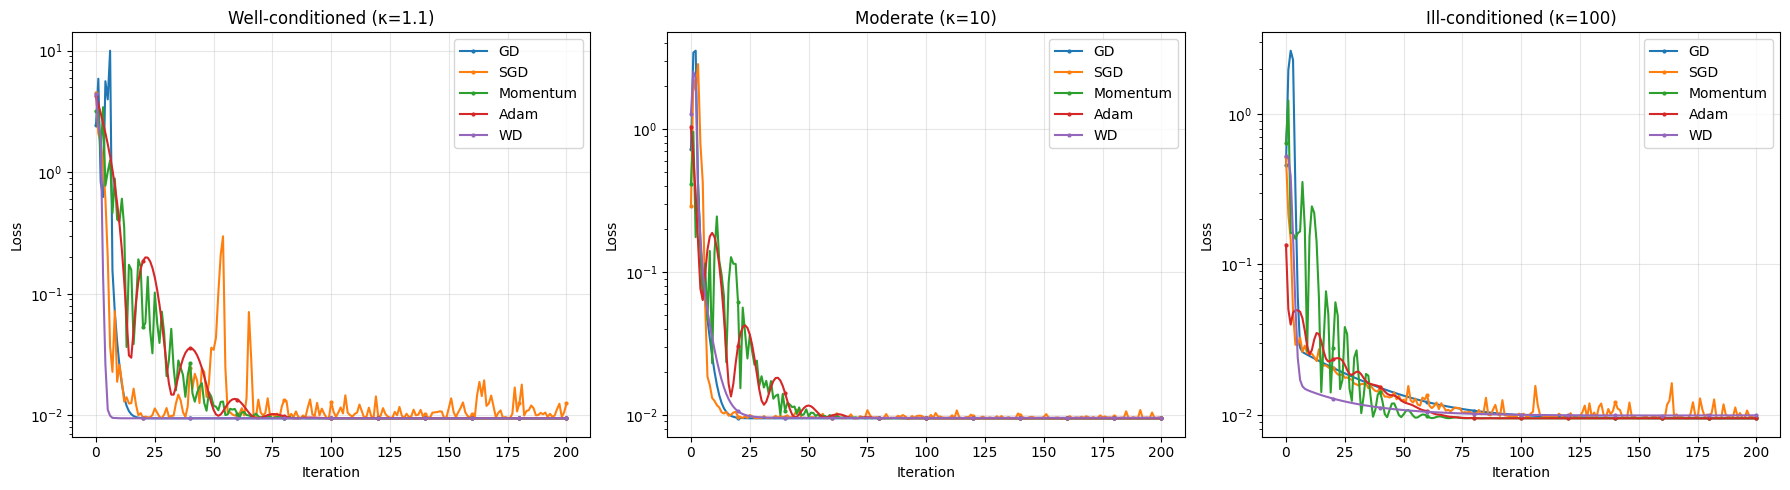

In [30]:
# ===================================
# PLOT 1: Loss Convergence Comparison
# ===================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (description, results) in enumerate(all_results.items()):
    ax = axes[idx]
    optimizer_info = results['optimizer_info']

    for name, (_, _, losses) in optimizer_info.items():
        if not np.isnan(losses).any():
            ax.plot(losses, label=name, marker='o', markersize=2, markevery=20)

    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title(description)
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

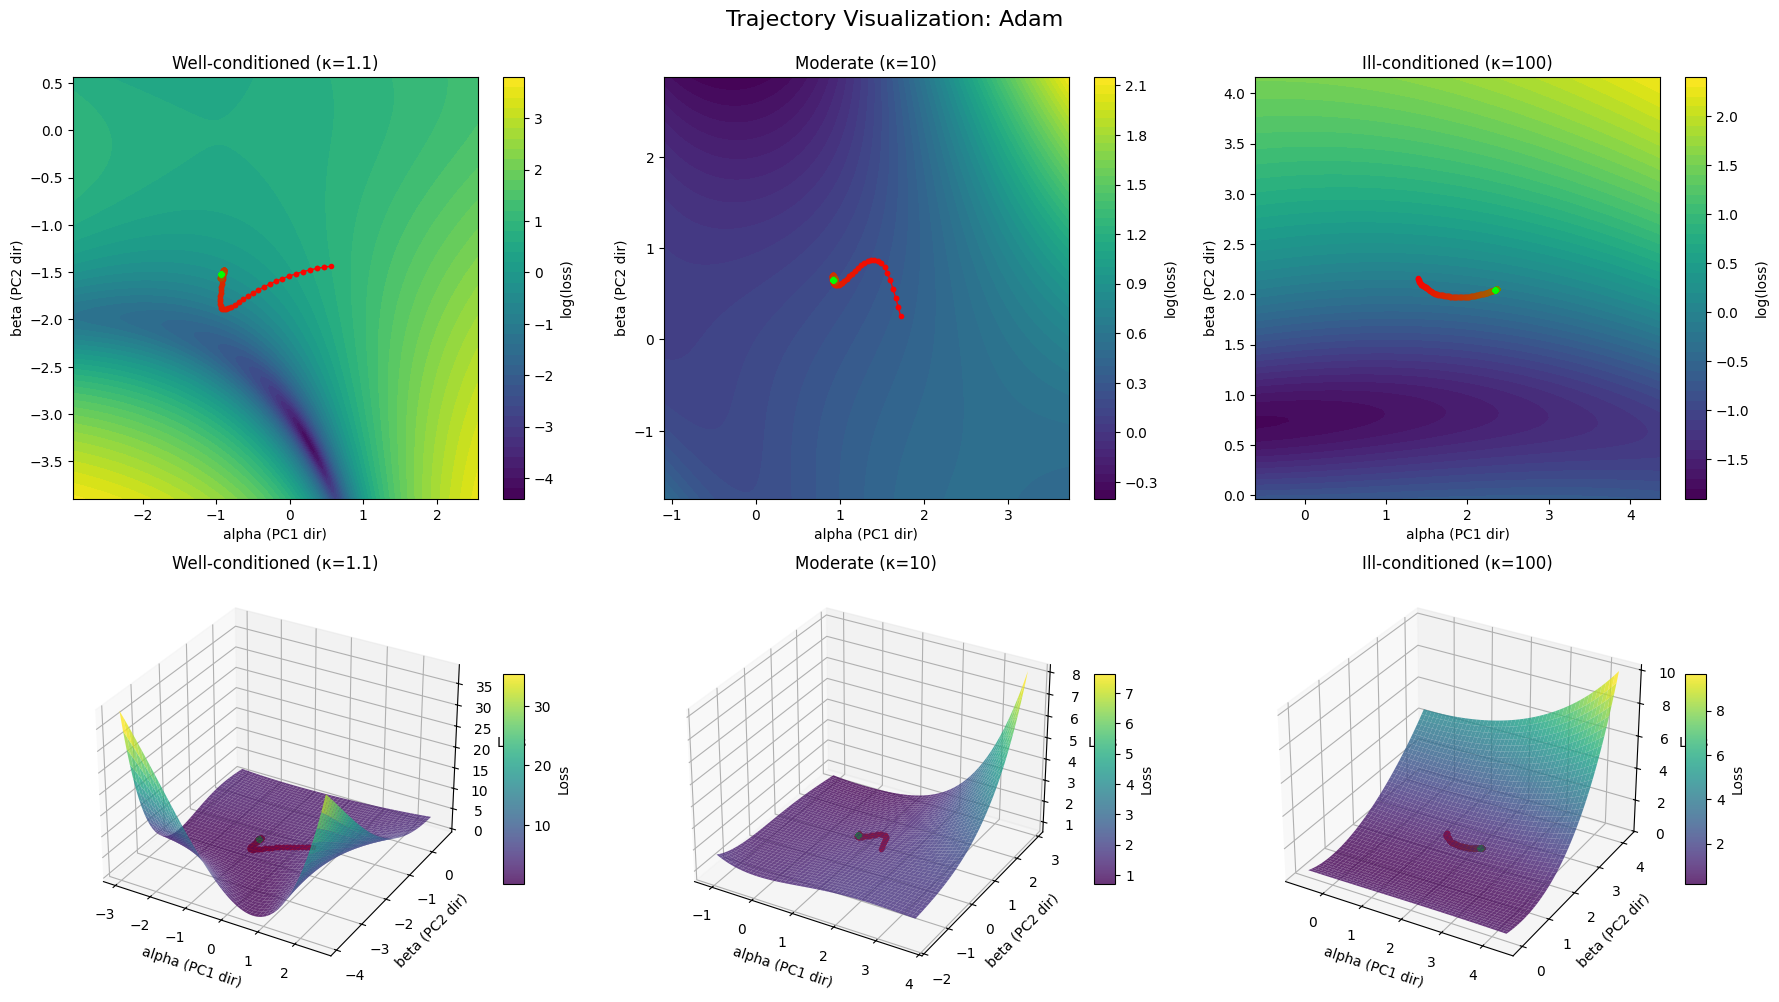

In [31]:
# ======================================================================
# PLOT 2: Trajectory Visualization (one optimizer across all conditions)
# ======================================================================
optimizer_to_viz = "Adam"

fig = plt.figure(figsize=(18, 10))

for idx, (description, results) in enumerate(all_results.items()):
    optimizer_info = results['optimizer_info']
    X, y = results['X'], results['y']
    width, depth, d_input = results['width'], results['depth'], results['d_input']
    traj, model, _ = optimizer_info[optimizer_to_viz]

    if np.isnan(traj).any():
        print(f"Skipping {description} - NaN detected")
        continue

    reference_params = results['reference_params']

    pca = PCA(n_components=2)
    pca.fit(traj - reference_params)
    shared_directions = pca.components_

    # Compute plot ranges
    proj = (traj - reference_params) @ shared_directions.T
    traj_alpha_min, traj_alpha_max = proj[:, 0].min(), proj[:, 0].max()
    traj_beta_min, traj_beta_max = proj[:, 1].min(), proj[:, 1].max()

    # Make loss surface range LARGER than trajectory range
    padding = 2.0  # Increase this for more surface shown
    alpha_range = (traj_alpha_min - padding, traj_alpha_max + padding)
    beta_range = (traj_beta_min - padding, traj_beta_max + padding)

    # 2D plot (top row)
    ax_2d = fig.add_subplot(2, 3, idx + 1)
    plot_loss_surface_2d_pca(model, X, y, f"{description}", alpha_range, beta_range,
                             traj, reference_params, ax_2d, shared_directions)

    # 3D plot (bottom row)
    ax_3d = fig.add_subplot(2, 3, idx + 4, projection='3d')
    plot_loss_surface_3d_pca(model, X, y, f"{description}", traj, alpha_range, beta_range,
                             reference_params, ax_3d, shared_directions)

fig.suptitle(f"Trajectory Visualization: {optimizer_to_viz}", fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

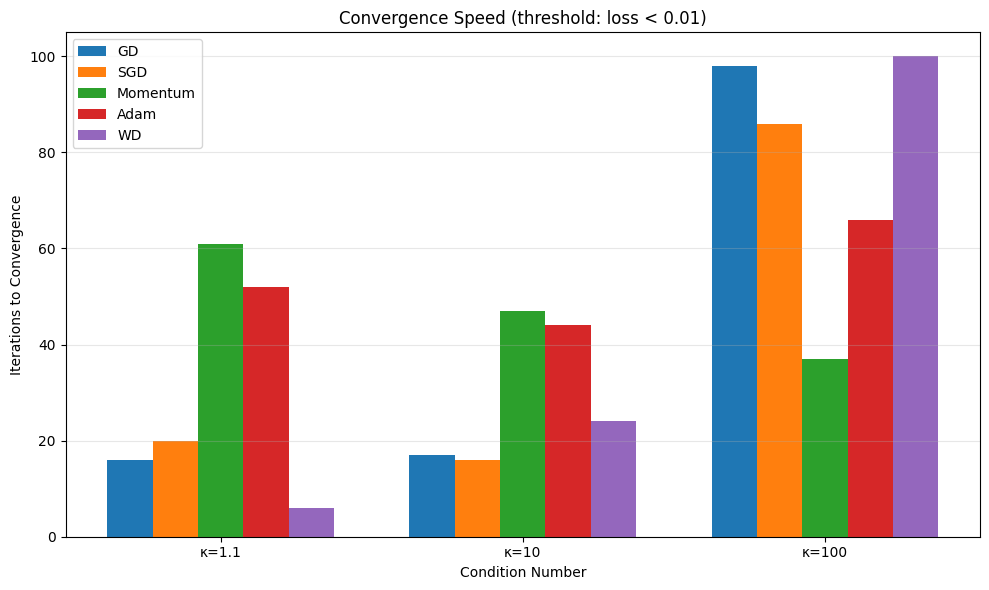

In [33]:
# ====================================
# PLOT 3: Convergence Speed Comparison
# ====================================
threshold = 0.01

convergence_data = {name: [] for name in ["GD", "SGD", "Momentum", "Adam", "WD"]}

for description, results in all_results.items():
    optimizer_info = results['optimizer_info']
    for name, (_, _, losses) in optimizer_info.items():
        converged_iter = np.where(losses < threshold)[0]
        if len(converged_iter) > 0:
            convergence_data[name].append(converged_iter[0])
        else:
            convergence_data[name].append(N_STEPS)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(conditions))
width_bar = 0.15

for idx, (name, iters) in enumerate(convergence_data.items()):
    ax.bar(x + idx*width_bar, iters, width_bar, label=name)

ax.set_xlabel('Condition Number')
ax.set_ylabel('Iterations to Convergence')
ax.set_title(f'Convergence Speed (threshold: loss < {threshold})')
ax.set_xticks(x + width_bar * 2)
ax.set_xticklabels([desc.split('(')[1].strip(')') for _, desc in conditions])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

^ improvements for this:
i think convergence speed should be averaged across experiments, not just for one experiment

# Convergence Tracking

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


def track_convergence(model_class, X, Y, optim_name='SGD', lr=0.01, batch_size=100,
                      weight_decay=0.0, momentum=0.0, epochs=10, width=20, depth=2, d=2,
                      device='cpu', seed=None, clip_grad=True):
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model = model_class(width=width, depth=depth, d=d).to(device)

    if optim_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    elif optim_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optim_name == 'SGDwd':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer {optim_name}")

    criterion = F.mse_loss
    norm_progression, loss_progression = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            epoch_loss += loss.item() * x_batch.size(0)

        avg_loss = epoch_loss / len(dataset)
        layer_norms = [p.data.norm().item() for p in model.parameters()]
        norm_progression.append(layer_norms)
        loss_progression.append(avg_loss)

        if epoch in [0, epochs//2, epochs-1]:
            norm_str = ", ".join([f"{n:.3f}" for n in layer_norms])
            print(f"Epoch {epoch+1}/{epochs}: loss={avg_loss:.6f}, norms=[{norm_str}]")

    return norm_progression, loss_progression, model

In [ ]:
# --- Parameters & eigenvalue setups ---
depth = 4
width = 20
epochs = 20
batch_size = 100
optimizers = ['SGD with Momentum', 'Adam', 'SGD with Weight Decay']
lr_dict = {'SGD with Momentum': 0.01, 'Adam': 0.005, 'SGD with Weight Decay': 0.01}
eigvals_list = [[1, 0.9], [0.1, 0.09], [0.001, 0.0009]]

results = {}

# --- Run convergence tracking for all optimizers ---
for eigvals in eigvals_list:
    print(f"\n--- Eigenvalues: {eigvals} ---")
    X_np, y_np, _ = make_2d_eigen_data(n=1000, eigvals=eigvals, noise=max(eigvals), seed=1)
    X, y = torch.from_numpy(X_np).float(), torch.from_numpy(y_np).float()

    optimizer_losses, optimizer_norms = {}, {}

    for opt_name in optimizers:
        print(f"Running {opt_name}...")
        lr = lr_dict[opt_name] * max(eigvals)
        norms, losses, _ = track_convergence(
            model_class=Net,
            X=X,
            Y=y,
            optim_name=opt_name,
            lr=lr,
            batch_size=batch_size,
            epochs=epochs,
            width=width,
            depth=depth,
            d=2,
            device='cpu',
            seed=1,
            clip_grad=True
        )
        optimizer_norms[opt_name] = norms
        optimizer_losses[opt_name] = [l / max(eigvals) for l in losses]

    results[tuple(eigvals)] = {'norms': optimizer_norms, 'losses': optimizer_losses}

# --- Plot convergence ---
plt.figure(figsize=(10, 6))
for eigvals in eigvals_list:
    optimizer_losses = results[tuple(eigvals)]['losses']
    for opt_name, losses in optimizer_losses.items():
        plt.plot(losses, marker='o', label=f"{opt_name}, eig={eigvals}")

plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.title(f"Convergence of Losses (Depth={depth}, d=2) for Different Eigenvalue Covariances")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim

def track_convergence(model_class, X, Y, optim_name='SGD', lr=0.01, batch_size=100,
                      weight_decay=0.0, epochs=10, width=100, depth=2, d=5,
                      device='cpu', seed=None, clip_grad=False):
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = model_class(width=width, depth=depth, d=d).to(device)

    # Select optimizer
    if optim_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optim_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer {optim_name}")

    criterion = F.mse_loss

    norm_progression = []
    loss_progression = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
            optimizer.step()
            epoch_loss += loss.item() * x_batch.size(0)

        # Track per-epoch stats
        avg_loss = epoch_loss / len(dataset)
        layer_norms = [p.data.norm().item() for p in model.parameters()]
        norm_progression.append(layer_norms)
        loss_progression.append(avg_loss)

        if epoch in [0, epochs//2, epochs-1]:
            norm_str = ", ".join([f"{n:.3f}" for n in layer_norms])
            print(f"Epoch {epoch+1}/{epochs}: loss={avg_loss:.6f}, norms=[{norm_str}]")

    return norm_progression, loss_progression, model



--- Eigenvalues: [1, 0.9] ---
Training SGD...
Epoch 1/20: loss=2.490559, norms=[4.153, 4.363, 4.225, 0.893]
Epoch 11/20: loss=0.983285, norms=[4.049, 4.392, 4.205, 0.991]


/tmp/ipython-input-3750603363.py:39: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = criterion(output, y_batch)


Epoch 20/20: loss=0.974997, norms=[4.007, 4.400, 4.208, 1.045]
Training Adam...
Epoch 1/20: loss=2.345930, norms=[3.914, 4.644, 4.697, 1.079]
Epoch 11/20: loss=1.006579, norms=[3.117, 4.705, 4.834, 0.603]
Epoch 20/20: loss=0.971138, norms=[2.881, 4.719, 4.847, 0.555]

--- Eigenvalues: [0.1, 0.09] ---
Training SGD...
Epoch 1/20: loss=0.096732, norms=[4.609, 4.548, 4.484, 1.368]
Epoch 11/20: loss=0.012814, norms=[4.618, 4.557, 4.493, 1.395]
Epoch 20/20: loss=0.009593, norms=[4.620, 4.559, 4.495, 1.402]
Training Adam...
Epoch 1/20: loss=0.031447, norms=[4.605, 4.566, 4.495, 1.355]
Epoch 11/20: loss=0.010117, norms=[4.528, 4.532, 4.450, 1.297]
Epoch 20/20: loss=0.009702, norms=[4.500, 4.515, 4.437, 1.271]

--- Eigenvalues: [0.001, 0.0009] ---
Training SGD...
Epoch 1/20: loss=0.001003, norms=[4.609, 4.548, 4.483, 1.365]
Epoch 11/20: loss=0.001003, norms=[4.609, 4.548, 4.483, 1.365]
Epoch 20/20: loss=0.001003, norms=[4.609, 4.548, 4.483, 1.365]
Training Adam...
Epoch 1/20: loss=0.000978, nor

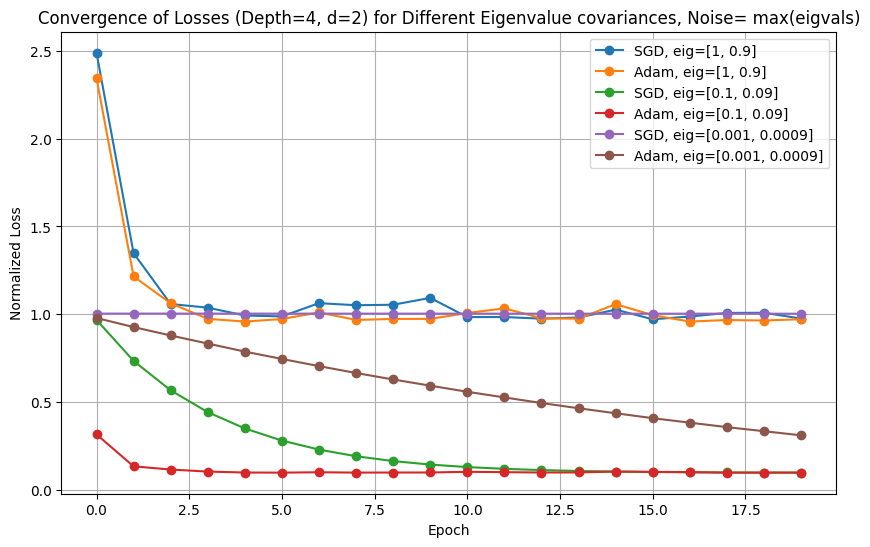

In [ ]:
depth = 4
width = 20
epochs = 20
batch_size = 100
lr_sgd = 0.1
lr_adam = 0.05
optimizers = ['SGD', 'Adam']
eigvals_list = [[1, .9], [0.1, 0.09], [0.001, 0.0009]]

results = {}
for eigvals in eigvals_list:
    print(f"\n--- Eigenvalues: {eigvals} ---")
    X, y, truew = make_2d_eigen_data(n=1000, eigvals=eigvals, noise=max(eigvals), seed=1)
    X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

    w_norms_dict = {}
    losses = {}

    for opt_name in optimizers:
        print(f"Training {opt_name}...")
        lr = lr_sgd * max(eigvals) if opt_name=='SGD' else lr_adam * max(eigvals)
        norms, loss, _ = track_convergence(
            model_class=Net,
            X=X,
            Y=y,
            optim_name=opt_name,
            lr=lr,
            batch_size=batch_size,
            epochs=epochs,
            width=width,
            depth=depth,
            d=2,
            device='cpu',
            seed=1
        )
        w_norms_dict[opt_name] = [n[1] for n in norms]
        losses[opt_name] = [n / max(eigvals) for n in loss]

    results[tuple(eigvals)] = losses

plt.figure(figsize=(10,6))
for eigvals in eigvals_list:
    w_norms_dict = results[tuple(eigvals)]
    for opt_name in optimizers:
        plt.plot(w_norms_dict[opt_name], label=f"{opt_name}, eig={eigvals}", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Normalized Loss")
plt.title(f"Convergence of Losses (Depth={depth}, d=2) for Different Eigenvalue covariances, Noise= max(eigvals)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torch

# --- Parameters ---
depth = 2
width = 200
epochs = 20
batch_size = 100
lr_sgd = 0.01
lr_adam = 0.01
optimizers = ['SGD', 'Adam']
eigvals_list = [[1, 0.5], [0.1, 0.05], [0.001, 0.0005]]

# --- Loop over eigenvalue sets ---
results = {}

for eigvals in eigvals_list:
    print(f"\n--- Eigenvalues: {eigvals} ---")
    X, y, _ = make_2d_eigen_data(n=1000, eigvals=eigvals, noise=0.1, seed=1)
    X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

    w_norms_dict = {}

    for opt_name in optimizers:
        print(f"Training {opt_name}...")
        lr = lr_sgd if opt_name=='SGD' else lr_adam
        norms, _ = track_convergence(
            model_class=Net,
            X=X,
            Y=y,
            optim_name=opt_name,
            lr=lr,
            batch_size=batch_size,
            epochs=epochs,
            width=width,
            depth=depth,
            d=2,
            device='cpu',
            seed=1
        )
        # Store only w norms
        w_norms_dict[opt_name] = [n[0] for n in norms]

    results[tuple(eigvals)] = w_norms_dict

# --- Plot results ---
plt.figure(figsize=(12,8))
for eigvals in eigvals_list:
    w_norms_dict = results[tuple(eigvals)]
    for opt_name in optimizers:
        plt.plot(w_norms_dict[opt_name], label=f"{opt_name}, eig={eigvals}", marker='o')
plt.xlabel("Epoch")
plt.ylabel("w Norm")
plt.title(f"Convergence of w Norms (Depth={depth}) for Different Eigenvalues")
plt.legend()
plt.grid(True)
plt.show()



--- Eigenvalues: [1, 0.5] ---
Training SGD...


NameError: name 'depht' is not defined

# Old code :P

In [ ]:
# DATA PARAMETERS
N_SAMPLES = 1000
D_INPUT = 20
D_EFFECTIVE = 2

# NETWORK PARAMETERS
WIDTH = 20
DEPTH = 3
N_STEPS = 200

# Generate rank-deficient data
X_np, y_np, w_true, null_space_basis = make_rank_deficient_data(
    n=N_SAMPLES, d_input=D_INPUT, d_effective=D_EFFECTIVE, noise=0.1, seed=1
)
X = torch.from_numpy(X_np).float()
y = torch.from_numpy(y_np).float()

# Train all optimizers
# IMPORTANT: Don't initialize one Net() instance and share it across all optimizers.
# Initialize a new Net() instance in each optimizer's argument.
traj_gd, model_gd, losses_gd = gradient_descent(
    Net(width=WIDTH, depth=DEPTH, d=D_INPUT), X, y, lr=0.15, n_steps=N_STEPS)
traj_sgd, model_sgd, losses_sgd = sgd(
    Net(width=WIDTH, depth=DEPTH, d=D_INPUT), X, y, lr=0.1, n_steps=N_STEPS)
traj_momentum, model_momentum, losses_momentum = gradient_descent_momentum(
    Net(width=WIDTH, depth=DEPTH, d=D_INPUT), X, y, lr=0.1, momentum=0.9, n_steps=N_STEPS)
traj_adam, model_adam, losses_adam = gradient_descent_adam(
    Net(width=WIDTH, depth=DEPTH, d=D_INPUT), X, y, lr=0.005, n_steps=N_STEPS)
traj_sgdwd, model_sgdwd, losses_sgdwd = sgd_weight_decay(
    Net(width=WIDTH, depth=DEPTH, d=D_INPUT), X, y, lr=0.1, weight_decay=0.01, n_steps=N_STEPS)

optimizer_info = {
    "Gradient Descent": (traj_gd, model_gd, losses_gd),
    "SGD": (traj_sgd, model_sgd, losses_sgd),
    "SGD with Momentum": (traj_momentum, model_momentum, losses_momentum),
    "Adam": (traj_adam, model_adam, losses_adam),
    "SGD with Weight Decay": (traj_sgdwd, model_sgdwd, losses_sgdwd)
}

# Print final losses
print("\n=== FINAL LOSSES ===")
for name, (_, _, losses) in optimizer_info.items():
    print(f"{name}: {losses[-1]:.6f}")

# Compute shared PCA directions from all trajectories
all_trajectories = np.vstack([traj for traj, _, _ in optimizer_info.values()
                               if not np.isnan(traj).any()])
reference_params = torch.cat([p.detach().flatten() for p in
                              Net(width=WIDTH, depth=DEPTH, d=D_INPUT).parameters()]).numpy()

pca_shared = PCA(n_components=2)
pca_shared.fit(all_trajectories - reference_params)
shared_directions = pca_shared.components_
print(f"PCA explained variance: {pca_shared.explained_variance_ratio_}")

# Compute plot ranges (auto-scale to fit all trajectories with 30% padding)
all_traj_proj = []
for traj, _, _ in optimizer_info.values():
    if not np.isnan(traj).any():
        proj = (traj - reference_params) @ shared_directions.T
        all_traj_proj.extend(proj)

all_traj_proj = np.array(all_traj_proj)
alpha_range = (all_traj_proj[:, 0].min() * 1.3, all_traj_proj[:, 0].max() * 1.3)
beta_range = (all_traj_proj[:, 1].min() * 1.3, all_traj_proj[:, 1].max() * 1.3)

# Plot trajectories
for name, (traj, model, _) in optimizer_info.items():
    if np.isnan(traj).any():
        print(f"Skipping {name} - NaN detected")
        continue

    fig = plt.figure(figsize=(10, 4))
    ax_2d = fig.add_subplot(121)
    ax_3d = fig.add_subplot(122, projection='3d')

    plot_loss_surface_2d_pca(model, X, y, f"2D: {name}", alpha_range, beta_range,
                             traj, reference_params, ax_2d, shared_directions)
    plot_loss_surface_3d_pca(model, X, y, f"3D: {name}", traj, alpha_range, beta_range,
                             reference_params, ax_3d, shared_directions)
    plt.tight_layout()
    plt.show()

In [ ]:
# Plot loss convergence
plt.figure(figsize=(10, 6))
for name, (_, _, losses) in optimizer_info.items():
    if not np.isnan(losses).any():
        plt.plot(losses, label=name, marker='o', markersize=3)

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Convergence Comparison")
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()